#### (Settings)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Priorities: CUDA -> MPS -> CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Device: CUDA (NVIDIA GPU)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Device: MPS (Mac Silicon)")
else:
    device = torch.device("cpu")
    print("Device: CPU")

Device: CUDA (NVIDIA GPU)


## 1. Load Dataset and Preprocess

#### transform

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 256

# define trasform
transform = v2.Compose([
    v2.Resize(IMG_SIZE), #1. resize shorter edge into 64
    v2.CenterCrop(IMG_SIZE), #2. crop at the center(rectangle image -> square image)
    v2.ToImage(), #3. (H, W, C) -> (C, H, W)
    v2.ToDtype(torch.float32, scale=True), #4. Z[0, 255] -> R[0.0, 1.0]
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #5. Normalize [0.0, 1.0] -> [-1.0, 1.0]
])

# load data
train_set = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_set = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_set = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

# concaterate into one train dataset
dataset = ConcatDataset([train_set, val_set, test_set])
del train_set, val_set, test_set

# build dataloader
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
)

100%|██████████| 345M/345M [00:19<00:00, 17.5MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.34MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 38.1MB/s]


In [ ]:
# Check batch shape
dataloader_iterator = iter(dataloader) # dataloader: iterable -> dataloader_iterator: iterater
sample_batch = next(dataloader_iterator)[0] # bring only features of a batch, not labels
print(f"Shape of Each Batch: {sample_batch.shape}")

Shape of Each Batch: torch.Size([256, 3, 64, 64])


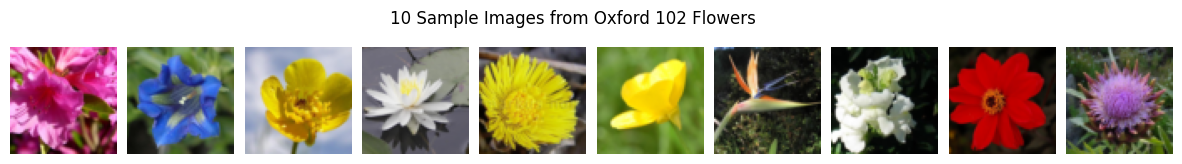

In [ ]:
# Visualize 10 sample images
## fetch a single batch for visualization
images = next(dataloader_iterator)[0]

## initialize subplots
fig, axes = plt.subplots(1, 10, figsize=(15, 3)) # fig: top-level container, # axes: numpy array of each grid
plt.subplots_adjust(wspace=0.1)

## plot each subplots
for i in range(10):
  img = images[i]
  img = (img * 0.5) + 0.5 # unnormalize to [0, 1] for visualization
  img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
  axes[i].imshow(img.cpu().numpy()) # display image
  axes[i].axis('off')

plt.suptitle("10 Sample Images from Oxford 102 Flowers", y=0.8)
plt.show()

## 2. Diffusion Schedule (Forward Process)
일단 Linear만 하고 나중에 Cosine이랑 Offset Cosine 추가

sig_rates^2 + nos_rates^2 = 1

In [ ]:
def linear_diffusion_schedule(T=1000):
  # beta rates
  min_beta = 0.0001
  max_beta = 0.02

  # betas, alphas, alpha_bars
  betas = torch.linspace(min_beta, max_beta, T, device=device)
  alphas = 1 - betas
  alpha_bars = torch.cumprod(alphas, dim=0)

  # signal rates, noise rates
  signal_rates = torch.sqrt(alpha_bars)
  noise_rates = torch.sqrt(1 - alpha_bars)

  return signal_rates, noise_rates, alphas # shape: torch.Size([1000])

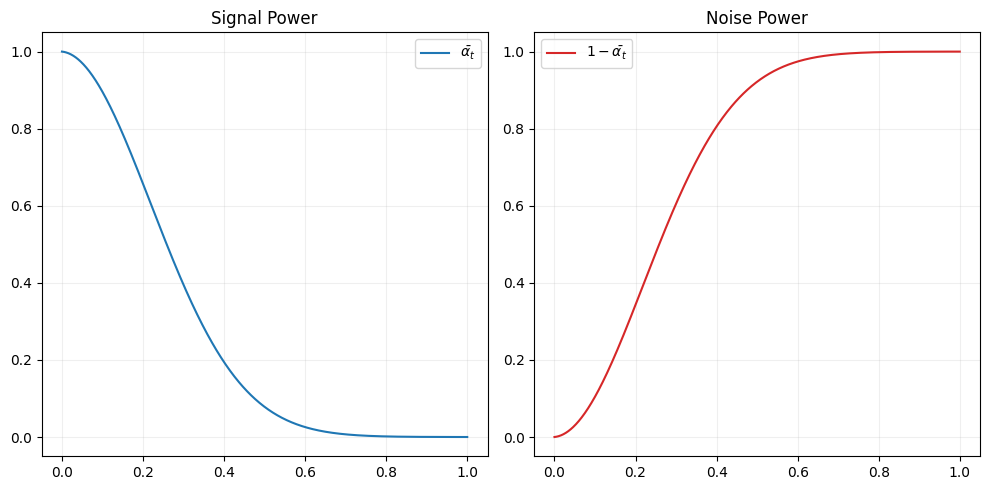

In [ ]:
# visualize signal power & noise power
timesteps = torch.linspace(0, 1, 1000) # Visualization works in CPU
sig_rates, nos_rates, _ = linear_diffusion_schedule() # on MPS/GPU
sig_rates = sig_rates.detach().cpu() # move to CPU
nos_rates = nos_rates.detach().cpu()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

## plot signal power
axes[0].plot(timesteps, sig_rates**2, color="tab:blue", label=r"$\bar{\alpha_t}$")
axes[0].legend()
axes[0].set_title("Signal Power")
axes[0].grid(True, alpha=0.2)

## plot noise power
axes[1].plot(timesteps, nos_rates**2, color="tab:red", label=r"$1-\bar{\alpha_t}$")
axes[1].legend()
axes[1].set_title("Noise Power")
axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

## 3. Model

### 2) Residual Block

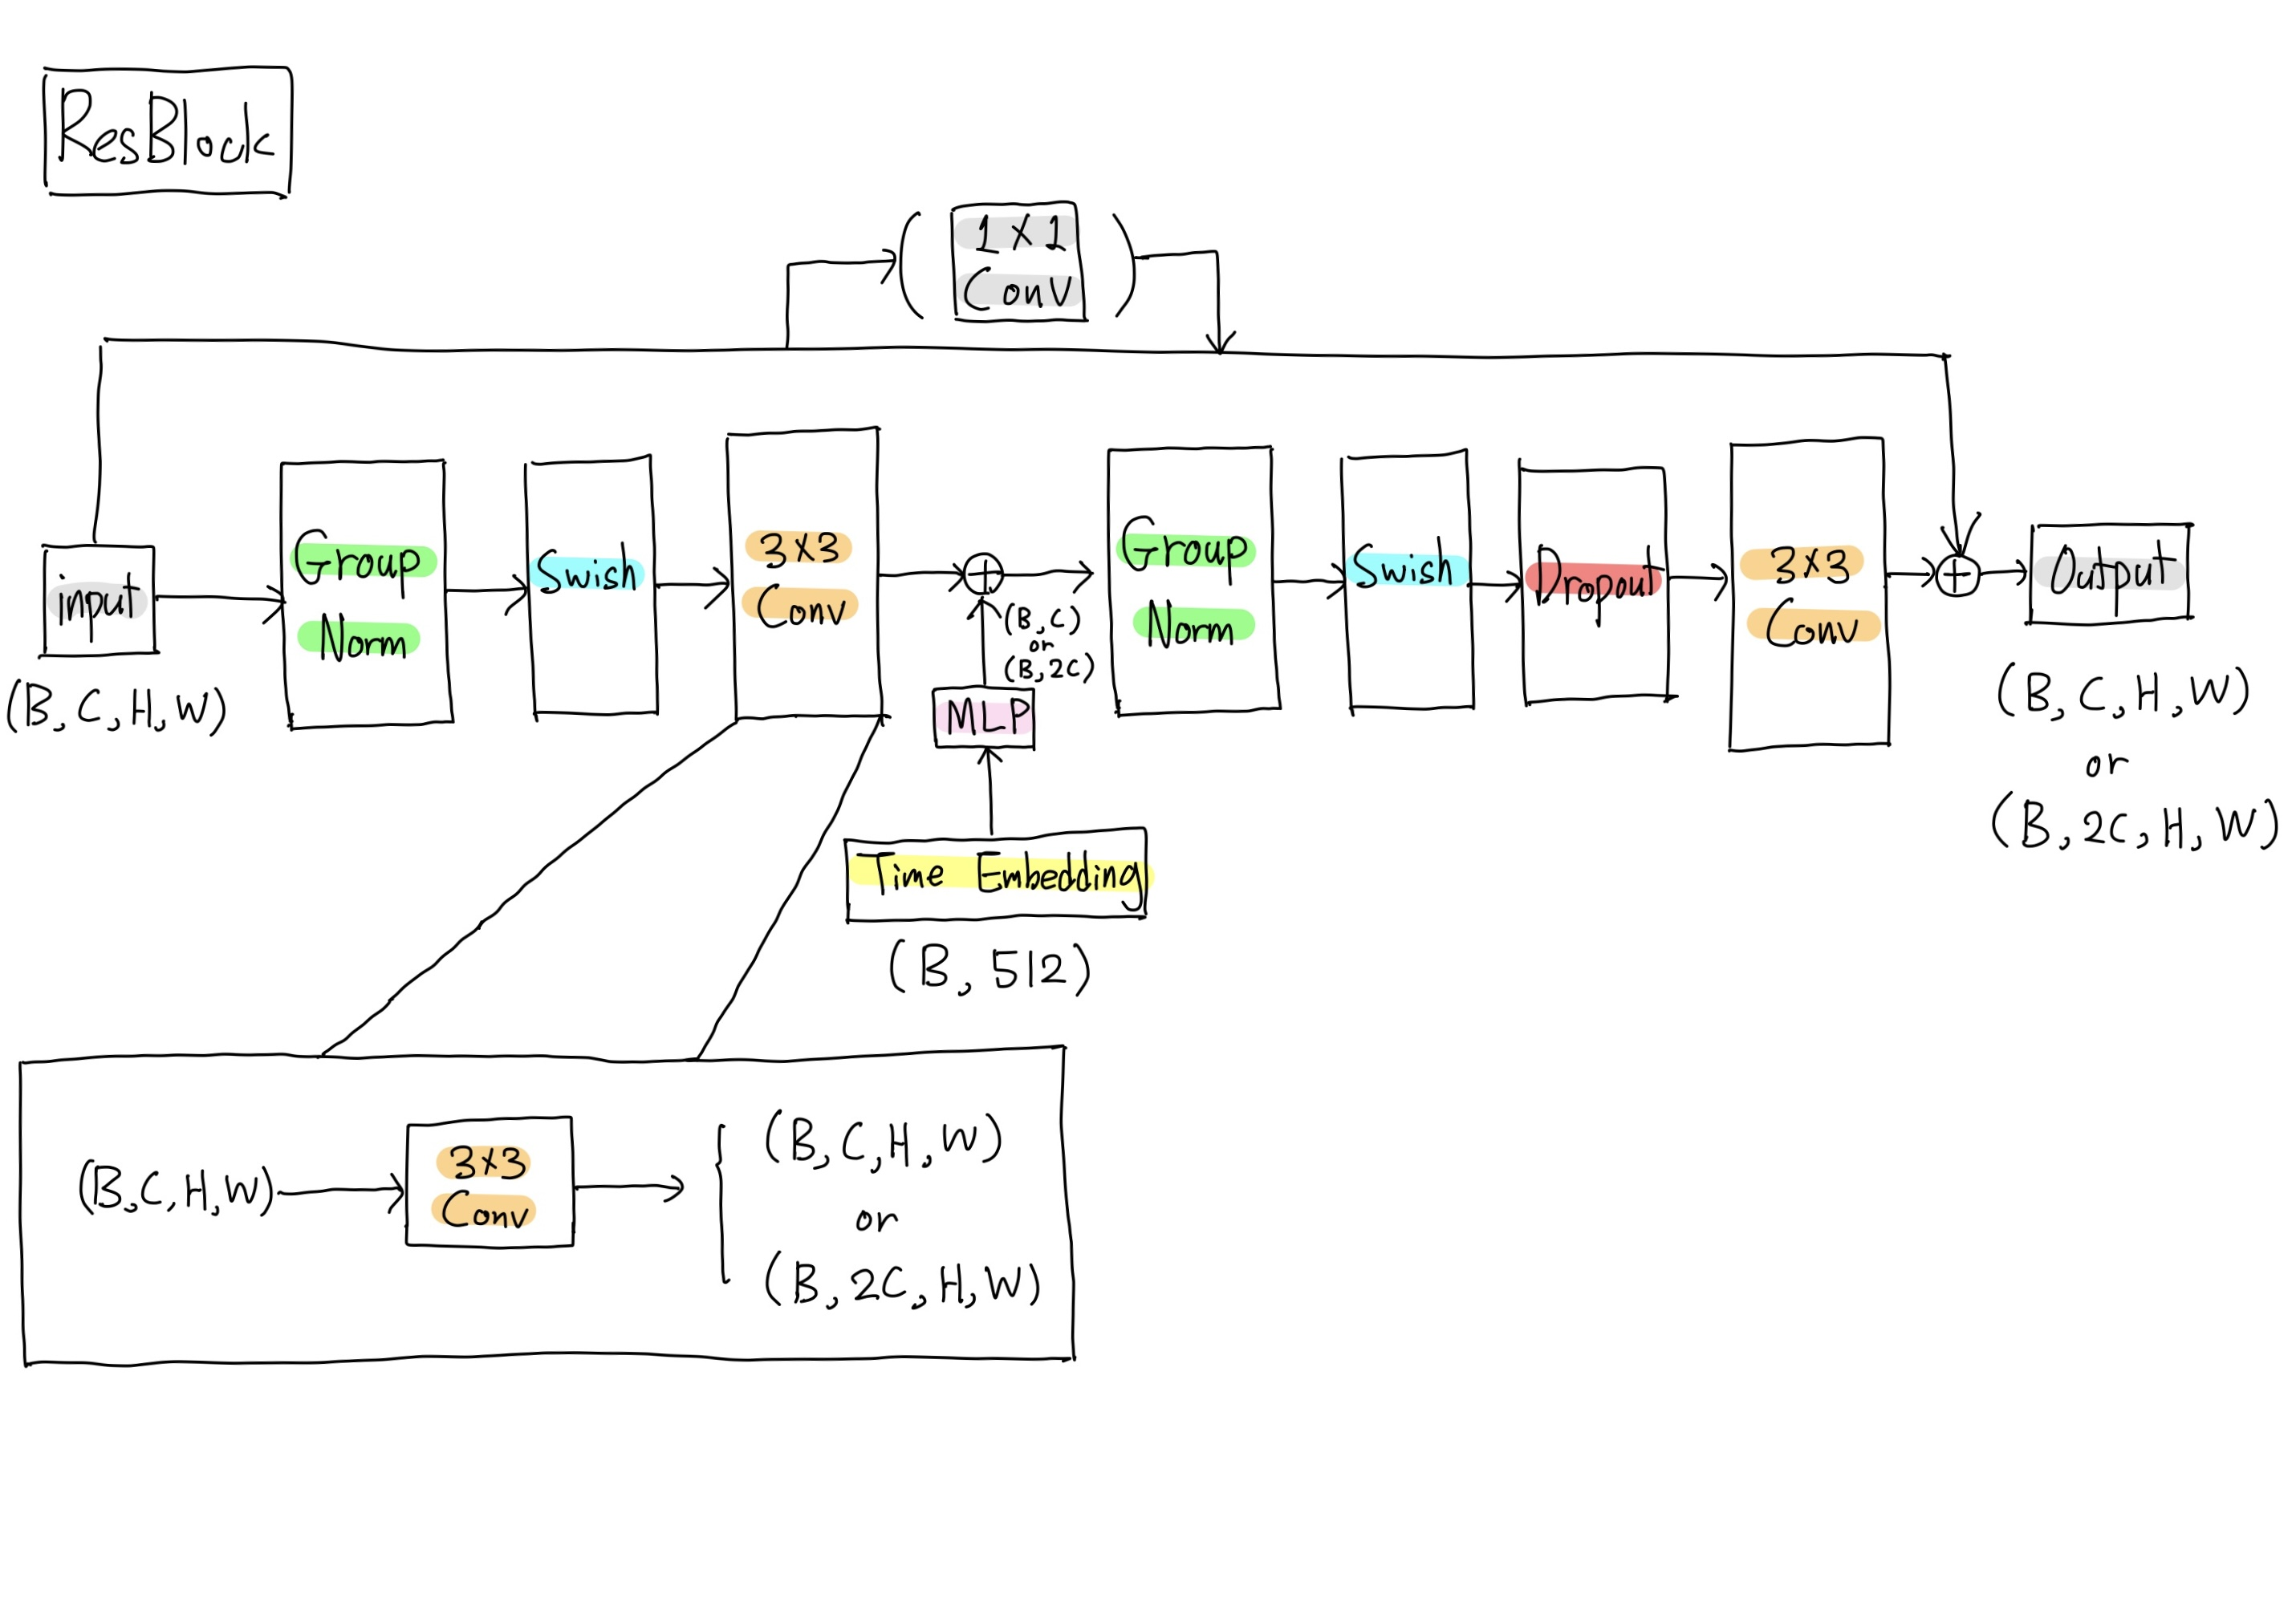

#### i) Sinusoidal Time Embedding

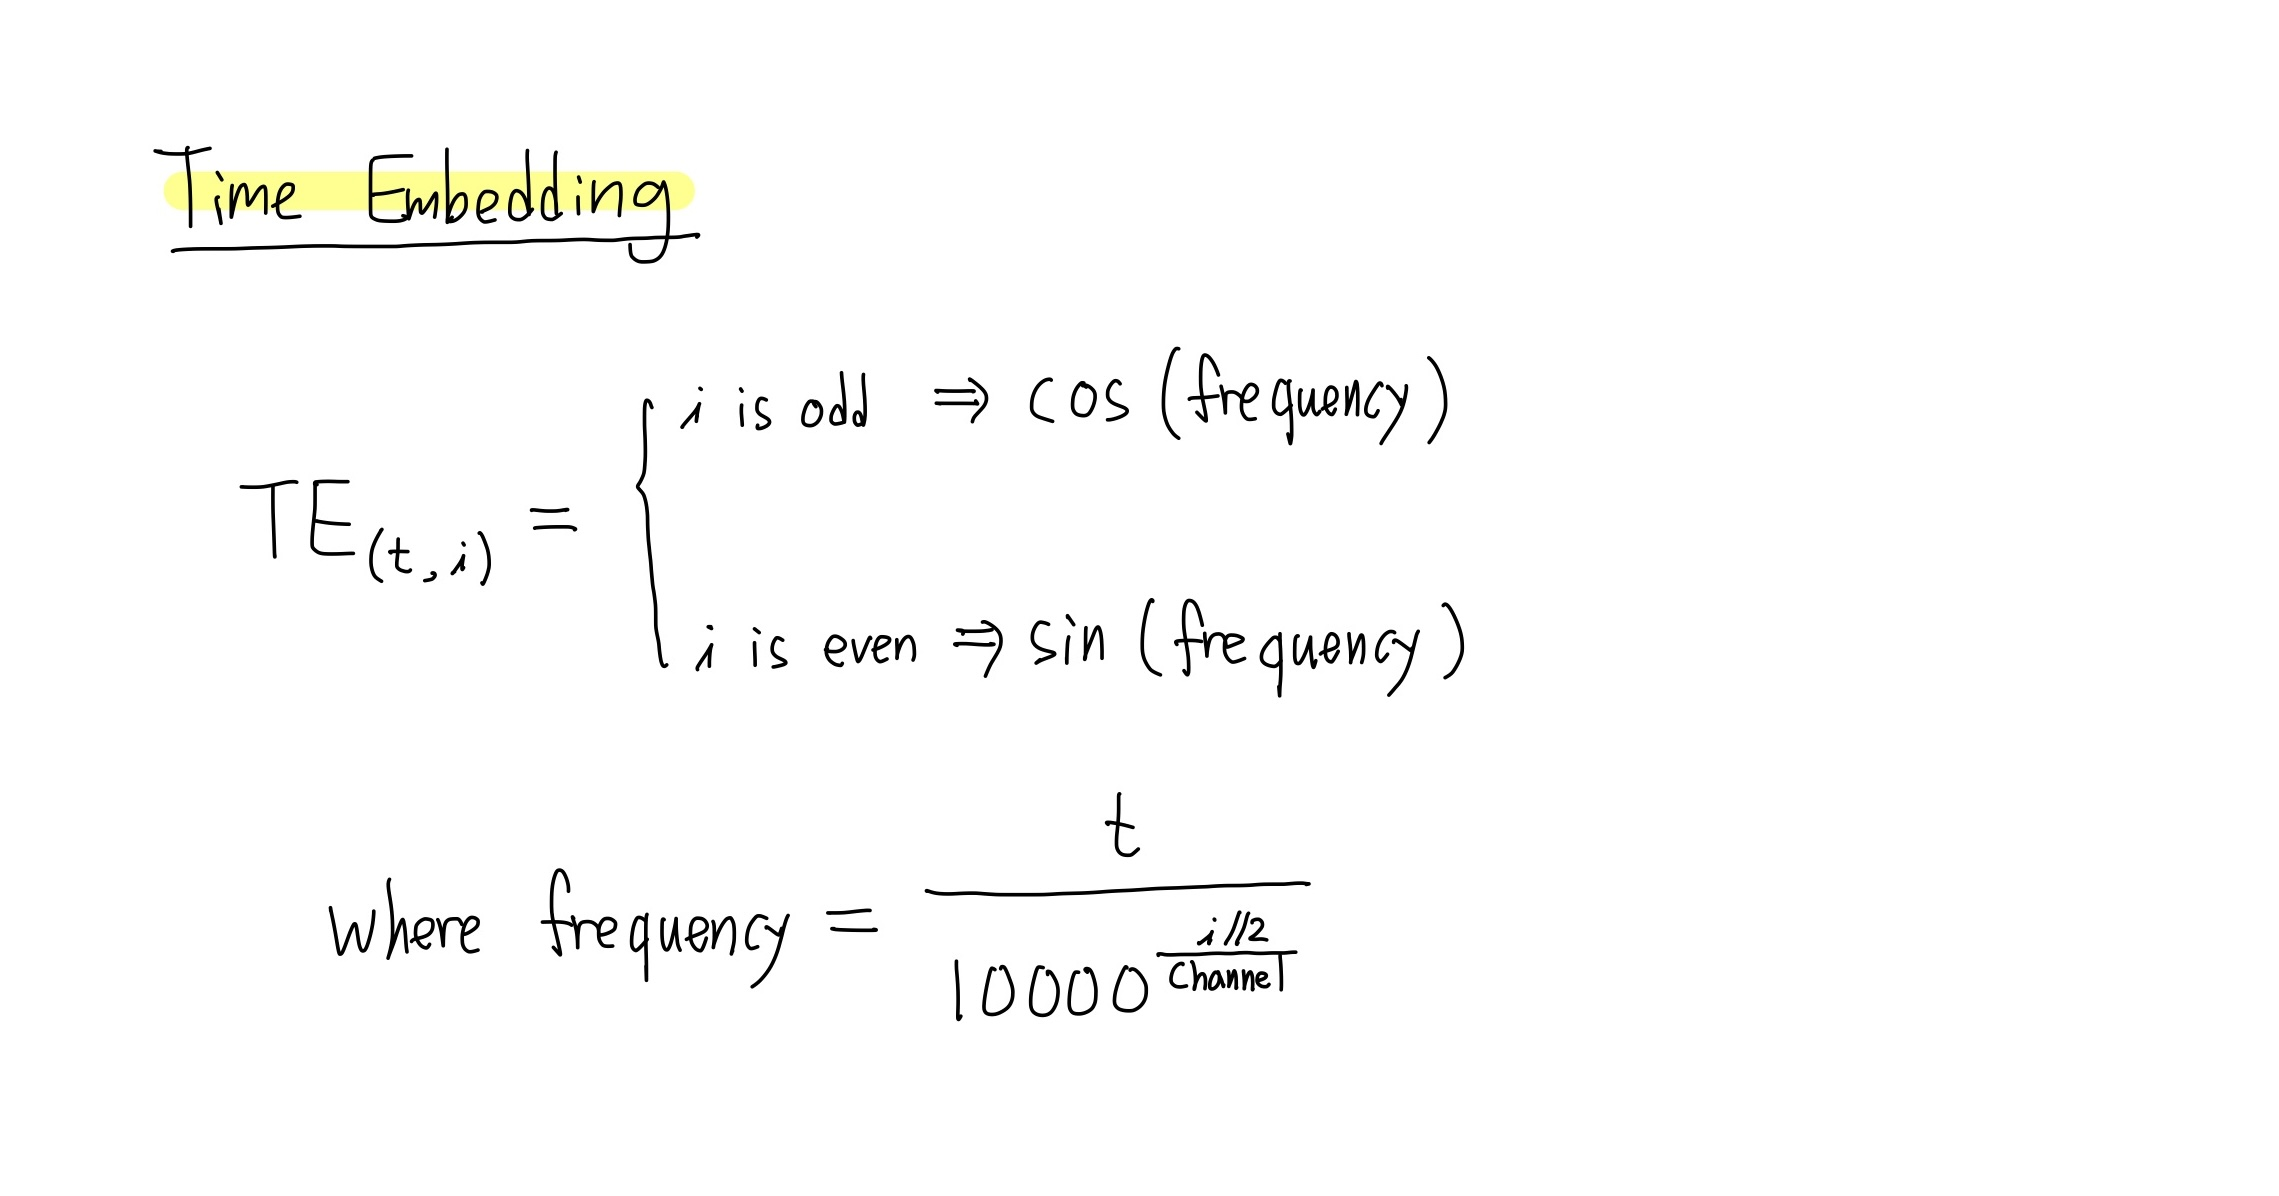

In [ ]:
class TimeEmbeddingBlock(nn.Module):
  def __init__(self, first_dim=128, global_dim=512):
    super().__init__()
    '''self.dims = torch.arange(first_dim // 2) -> saved on CPU!''' #dims: [0, 1, 2, 3, ..., {(first_dim//2 - 1)=63}]
    self.register_buffer('dims', torch.arange(first_dim // 2)) # auto move to GPU

    # set mlp phase(128 -> Linear Layer -> 512 -> SiLU -> 512 -> Linear Layer -> 512)
    self.mlp = nn.Sequential(
        nn.Linear(first_dim, global_dim),
        nn.SiLU(),
        nn.Linear(global_dim, global_dim)
    )

  # First time embedding (BATCH_SIZE, first_dim=128)
  def generate_first_time_embeddings(self, times):
    times = times.float() # to operate with float
    B = times.shape[0] # B = BATCH_SIZE

    # denominators & frequencies
    denominators = 1/(10000**(self.dims/self.dims[-1])) # exponent covers whole range [0, 1]
    frequencies = times.reshape(B, -1)@denominators.reshape(1, -1) # (BATCH_SIZE, (first_dim//2) = 64)

    # make each half(cos, sin) and concatenate
    odd_half = torch.cos(frequencies) # left half
    even_half = torch.sin(frequencies) # right half
    first_time_embeddings = torch.cat((odd_half, even_half), dim=1) #(BATCH_SIZE, first_dim=128)

    return first_time_embeddings # returns (B, fist_dim=128)

  # Global time embeddings (BATCH_SIZE, global_dim=512)
  def forward(self, times):
    x = self.generate_first_time_embeddings(times) # generates first time embeddings (BATCH_SIZE, first_dim=128)
    global_time_embeddings = self.mlp(x) # generates global time embeddings (BATCH_size, global_dim=512)

    return global_time_embeddings # returns (B, global_dim=512). It must be reshaped to (B, C)

#### ii) Residual Block

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, dim_t=512): # fixed num_groups 32
    super().__init__()

    self.proj1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
    self.proj2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)

    # If in/out channels are different -> we need 1*1 Conv / else -> Identitiy
    if in_channels != out_channels:
      self.proj_add = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
    else:
      self.proj_add = nn.Identity()

    self.proj_t = nn.Sequential(
        nn.SiLU(),                      # i) activation(SiLU)
        nn.Linear(dim_t, out_channels), # ii) reshape by a Linear Layer
    )

    self.groupnorm1 = nn.GroupNorm(num_groups=32, num_channels=in_channels)
    self.groupnorm2 = nn.GroupNorm(num_groups=32, num_channels=out_channels)

    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x, global_time_emb):
    # prepare for residual connection
    x_add = x # save x
    x_add = self.proj_add(x_add) # reshape if needed

    # Before Adding Time Embedding
    x = self.groupnorm1(x) # Group Norm 1
    x = F.silu(x) # Swish
    x = self.proj1(x) # 3*3 Conv 1

    # Reshape and Add Time Embedding
    t = self.proj_t(global_time_emb) # (BATCH, dim_t=512) -> (BATCH, out_channels)
    t = t[:, :, None, None] # (BATCH, out_channels) -> (BATCH, out_channels, 1, 1)
    x = x + t

    # After Adding Time Embedding
    x = self.groupnorm2(x) # Group Norm 2
    x = F.silu(x) # Swish
    x = self.dropout(x) # Droupout
    x = self.proj2(x) # 3*3 Conv 2
    x = x + x_add # residual connection

    return x

### 3) DownSample / UpSample

In [ ]:
# DownSample
class DownSample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=1, stride=2)

    def forward(self, x):
        x = self.downsample(x)
        return x

# UpSample
class UpSample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest') # just upscale 1 pixel into 4 pixels
        self.proj = nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding = 1) # smooth out

    def forward(self, x):
        x = self.upsample(x)
        x = self.proj(x)
        return x

### 4) Attention Block

In [ ]:
# AttentionBlock
class AttentionBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

        # group normalization
        self.groupnorm = nn.GroupNorm(num_groups=32, num_channels=dim)

        # attention parameters (W_Q, W_K, W_V)
        self.w_q = nn.Linear(dim, dim)  # w_q: (C, C)
        self.w_k = nn.Linear(dim, dim)  # w_k: (C, C)
        self.w_v = nn.Linear(dim, dim)  # w_v: (C, C)

        # 1*1 convolution
        self.proj = nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=1)

    def forward(self, x):
        x_add = x # for residual connection
        B, C, H, W = x.shape

        # GroupNorm before attention
        x = self.groupnorm(x)

        # reshape for attention: (B, C, H, W) -> (B, H * W, C)
        x = x.reshape(B, C, -1) # (B, C, H, W) -> (B, C, H * W)
        x = x.permute(0, 2, 1) # (B, C, H * W) -> (B, H * W, C)

        # Query, Key, Value
        q = self.w_q(x) # x @ w_q(k, v): (H * W, C) @ (C, C) -> (H * W, C)
        k = self.w_k(x)
        v = self.w_v(x)

        # Attention
        inner_q_k = q @ k.transpose(-1, -2) # (H * W, C) @ (C, H * W) -> (H * W, H * W)
        attention_x = (F.softmax((inner_q_k/C**0.5), dim=-1)) @ v # (H * W, H * W) @ (H * W, C) -> (H * W, C)

        # reshape as x for return
        attention_x = attention_x.permute(0, 2, 1) # (B, H * W, C) -> (B, C, H * W)
        attention_x = attention_x.reshape(B, C, H, W) # (B, C, H * W) -> (B, C, H, W)

        # Convolution layer
        attention_x = self.proj(attention_x)

        # residual connection
        x_output = attention_x + x_add

        return x_output

### 5) U-Net

In [ ]:
# Build U-Net
class U_Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Make Global Time Embedding generator instance
        self.t_emb_gen = TimeEmbeddingBlock()

        # Input Convolution
        self.input_conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)

        # Down 1
        self.Down1_ResBlock_1 = ResBlock(in_channels=64, out_channels=64)
        self.Down1_ResBlock_2 = ResBlock(in_channels=64, out_channels=64)
        self.Down1_DownSample = DownSample(dim=64)

        # Down 2
        self.Down2_ResBlock_1 = ResBlock(in_channels=64, out_channels=128)
        self.Down2_ResBlock_2 = ResBlock(in_channels=128, out_channels=128)
        self.Down2_DownSample = DownSample(dim=128)

        # Down 3
        self.Down3_ResBlock_1 = ResBlock(in_channels=128, out_channels=256)
        self.Down3_AttentionBlock = AttentionBlock(dim=256)
        self.Down3_ResBlock_2 = ResBlock(in_channels=256, out_channels=256)
        self.Down3_DownSample = DownSample(dim=256)

        # Down 4
        self.Down4_ResBlock_1 = ResBlock(in_channels=256, out_channels=512)
        self.Down4_ResBlock_2 = ResBlock(in_channels=512, out_channels=512)
        self.Down4_DownSample = DownSample(dim=512)

        # Middle
        self.Middle_ResBlock_1 = ResBlock(in_channels=512, out_channels=512)
        self.Middle_ResBlock_2 = ResBlock(in_channels=512, out_channels=512)
        self.Middle_AttentionBlock = AttentionBlock(dim=512)

        # Up 1
        self.Up1_UpSample = UpSample(dim=512)
        self.Up1_ResBlock_1 = ResBlock(in_channels=1024, out_channels=512)
        self.Up1_ResBlock_2 = ResBlock(in_channels=512, out_channels=512)

        # Up 2
        self.Up2_UpSample = UpSample(dim=512)
        self.Up2_ResBlock_1 = ResBlock(in_channels=768, out_channels=256)
        self.Up2_AttentionBlock = AttentionBlock(dim=256)
        self.Up2_ResBlock_2 = ResBlock(in_channels=256, out_channels=256)

        # Up 3
        self.Up3_UpSample = UpSample(dim=256)
        self.Up3_ResBlock_1 = ResBlock(in_channels=384, out_channels=128)
        self.Up3_ResBlock_2 = ResBlock(in_channels=128, out_channels=128)

        # Up 4
        self.Up4_UpSample = UpSample(dim=128)
        self.Up4_ResBlock_1 = ResBlock(in_channels=192, out_channels=64)
        self.Up4_ResBlock_2 = ResBlock(in_channels=64, out_channels=64)

        # Output Sequence
        self.Output_Seq = nn.Sequential(
            nn.GroupNorm(num_groups=32, num_channels=64),
            nn.SiLU(),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1)
        )

    def forward(self, x, t): # t:

        # make time embedding
        global_time_emb = self.t_emb_gen(t)
        # input
        x = self.input_conv(x)

        # Down 1
        x = self.Down1_ResBlock_1(x, global_time_emb)
        x = self.Down1_ResBlock_2(x, global_time_emb)
        skip_1 = x
        x = self.Down1_DownSample(x)

        # Down 2
        x = self.Down2_ResBlock_1(x, global_time_emb)
        x = self.Down2_ResBlock_2(x, global_time_emb)
        skip_2 = x
        x = self.Down2_DownSample(x)

        # Down 3
        x = self.Down3_ResBlock_1(x, global_time_emb)
        x = self.Down3_AttentionBlock(x)
        x = self.Down3_ResBlock_2(x, global_time_emb)
        skip_3 = x
        x = self.Down3_DownSample(x)

        # Down 4
        x = self.Down4_ResBlock_1(x, global_time_emb)
        x = self.Down4_ResBlock_2(x, global_time_emb)
        skip_4 = x
        x = self.Down4_DownSample(x)

        # Middle
        x = self.Middle_ResBlock_1(x, global_time_emb)
        x = self.Middle_AttentionBlock(x)
        x = self.Middle_ResBlock_2(x, global_time_emb)

        # Up 1
        x = self.Up1_UpSample(x)
        x = torch.cat((x, skip_4), dim=1)
        x = self.Up1_ResBlock_1(x, global_time_emb)
        x = self.Up1_ResBlock_2(x, global_time_emb)

        # Up 2
        x = self.Up2_UpSample(x)
        x = torch.cat((x, skip_3), dim=1)
        x = self.Up2_ResBlock_1(x, global_time_emb)
        x = self.Up2_AttentionBlock(x)
        x = self.Up2_ResBlock_2(x, global_time_emb)

        # Up 3
        x = self.Up3_UpSample(x)
        x = torch.cat((x, skip_2), dim=1)
        x = self.Up3_ResBlock_1(x, global_time_emb)
        x = self.Up3_ResBlock_2(x, global_time_emb)

        # Up 4
        x = self.Up4_UpSample(x)
        x = torch.cat((x, skip_1), dim=1)
        x = self.Up4_ResBlock_1(x, global_time_emb)
        x = self.Up4_ResBlock_2(x, global_time_emb)

        # Output Sequence
        x = self.Output_Seq(x)

        return x

### 6) DDPM (Training & Sampling Logic)

In [ ]:
class DDPM(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.u_net = model

        # generate signal_rates, noise_rates
        signal_rates, noise_rates, alphas = linear_diffusion_schedule()
        self.register_buffer('signal_rates', signal_rates) # attach to register buffer for migration to GPU
        self.register_buffer('noise_rates', noise_rates)
        self.register_buffer('alphas', alphas)

    def forward(self, x):

        '''Phase 1: Make Input = Noised image("noised_x")'''

        ## 1) generate "epsilon"
        epsilon = torch.randn_like(x) # noise ~ N(0, 1), shape: (B, C, H, W)

        ## 2) sample "t" form [0, 1, 2, ..., 999] uniformly
        t = torch.randint(0, 1000, (x.shape[0], ), device=x.device) # t: (B) int tensor

        ## 3) take "sig_rates" and "ns_rates" for calculation
        sig_rates = self.signal_rates[t] # sig_rates: (B) float tensor
        sig_rates = sig_rates.reshape(x.shape[0], 1, 1, 1) # sig_rates: (B, 1, 1, 1)

        ns_rates = self.noise_rates[t] # ns_rates: (B) float tensor
        ns_rates = ns_rates.reshape(x.shape[0], 1, 1, 1) # ns_rates: (B, 1, 1, 1)

        ## 4) make "noised_x"
        noised_x = sig_rates * x + epsilon * ns_rates


        '''Phase 2: Model Prediction'''
        pred_epsilon = self.u_net(noised_x, t) # pred_noise: (B, 3, H, W) float tensor


        '''Phase 3: Calculate Loss Function'''
        ## Loss(MSE): [sum of {(epsilon - pred_epsilon)^2}] / (B * C * H * W)
        ## mean of every pixel's error in a batch
        loss = F.mse_loss(pred_epsilon, epsilon)

        return loss

    # Posterior Sampling
    @torch.no_grad()
    def sample(self, num_of_sample, size=(3, 64, 64), device=device):
        # model input
        x_t = torch.randn(num_of_sample, *size).to(device) # x: (3, 64, 64) random noise
        denoise_process = [] # to visualize denoising process

        # x_1000 -> x_0
        for t in reversed(range(1000)): # t: 1000 -> 999 == t = 999

            # 1) epsilon_pred
            t_input = torch.full((num_of_sample, ), t, device=device, dtype=torch.long) # t_input: (B, )
            epsilon_pred = self.u_net(x_t, t_input)

            # 2) alpha_t, noise_rate, alpha_bar
            alpha = self.alphas[t].view(1, 1, 1, 1)
            ns_rate = self.noise_rates[t].view(1, 1, 1, 1)
            alpha_bar = self.signal_rates[t].view(1, 1, 1, 1) ** 2

            # 3) Posterior: predicted x_0
            x0_pred = (x_t - torch.sqrt(1 - alpha_bar) * epsilon_pred) / torch.sqrt(alpha_bar)
            x0_pred = torch.clamp(x0_pred, -1, 1) # x_0 must be in (-1, 1)

            # 4) previous alpha_bar
            if t > 0:
                prev_alpha_bar = self.signal_rates[t - 1].view(1, 1, 1, 1) ** 2
            else:
                prev_alpha_bar = torch.tensor(1.0).to(device)

            # 5) beta
            beta = 1 - alpha

            # 6) Weights for mean
            w1 = beta * torch.sqrt(prev_alpha_bar) / (1 - alpha_bar)
            w2 = (1 - prev_alpha_bar) * torch.sqrt(alpha) / (1 - alpha_bar)

            # 7) mean
            mean = w1 * x0_pred + w2 * x_t

            # 8) x_t {z ~ N(0, 1)}
            if t > 0:
                z = torch.randn_like(x_t)
                sigma = torch.sqrt(beta * (1 - prev_alpha_bar) / (1 - alpha_bar))
                x_t = mean + sigma * z
            else:
                x_t = mean

            # 9)
            if ((t + 1) % 100 == 0) or (t == 0): # save 11 steps
                denoise_process.append(x_t) # denoise_process: (t, Sample#, C, H, W)

        return x_t, denoise_process

## 4. Train

Epoch: 10/100: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s, loss=0.0552]


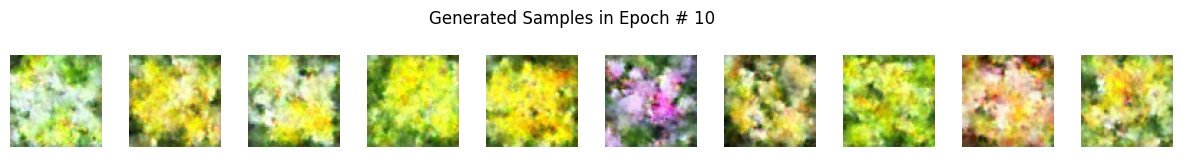

Epoch: 20/100: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s, loss=0.0381]


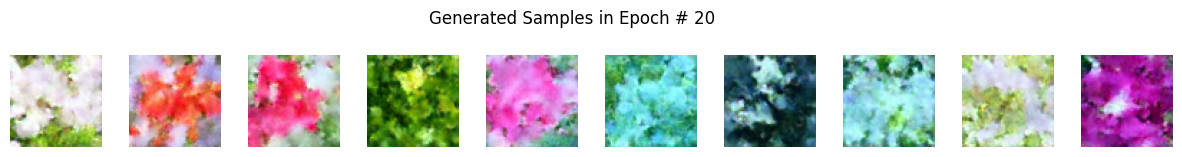

Epoch: 30/100: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s, loss=0.0347]


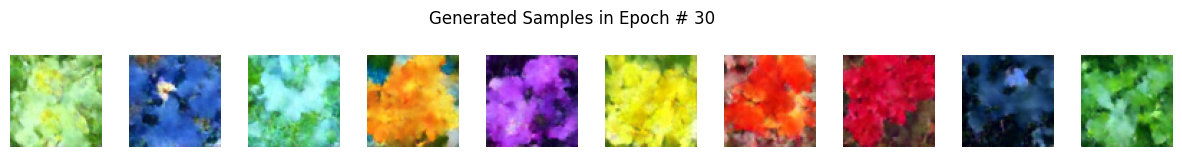

Epoch: 40/100: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s, loss=0.0428]


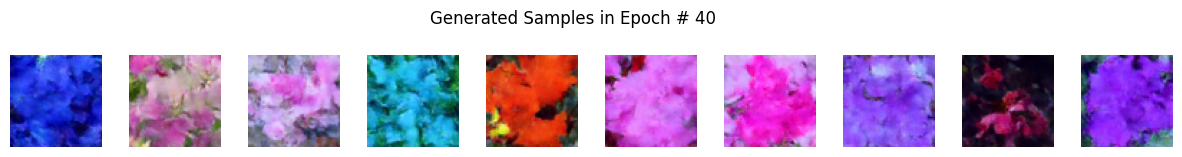

Epoch: 50/100: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s, loss=0.0438]


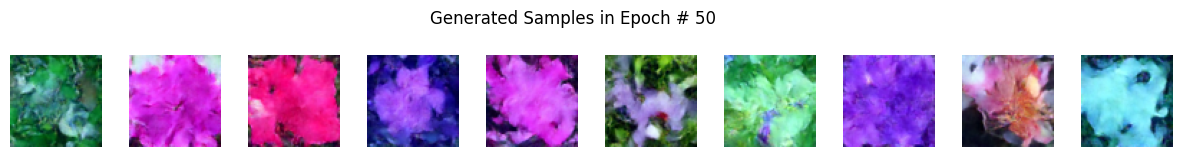

Epoch: 60/100: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s, loss=0.0348]


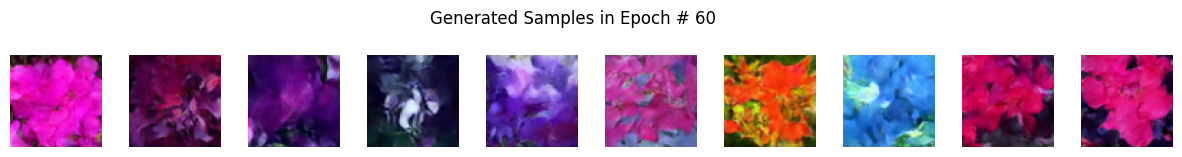

Epoch: 70/100: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s, loss=0.0339]


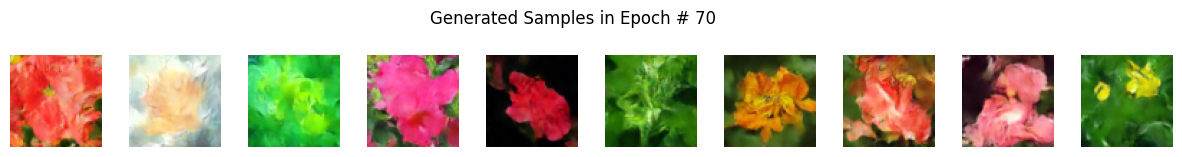

Epoch: 80/100: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s, loss=0.0245]


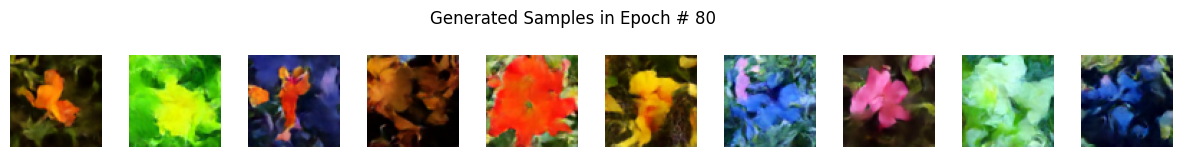

Epoch: 90/100: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s, loss=0.0325]


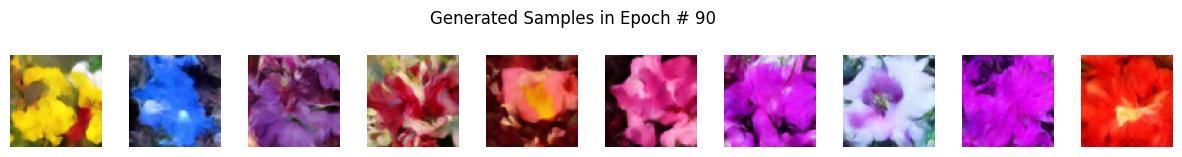

Epoch: 100/100: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s, loss=0.0316]


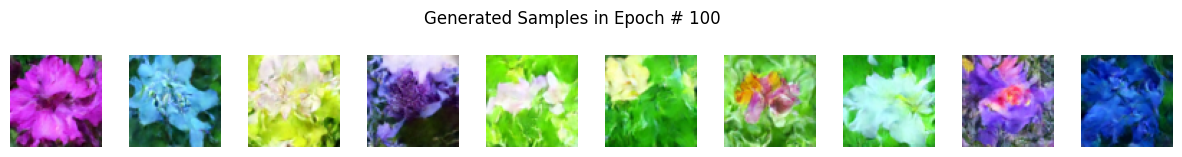

In [ ]:
# Hyperparameters for train
LEARNING_RATE = 2e-4
EPOCH_NUM = 100

# Optimization Setup(AdamW)
ddpm = DDPM(U_Net()).to(device) # model instance
optimizer = torch.optim.AdamW(ddpm.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # setup optimizer

# Loss Curve Ingredients
loss_vis = []

# Optimize
ddpm.train() # train mode

for epoch in range(EPOCH_NUM):
    pbar = tqdm(dataloader, desc=f"Epoch: {epoch+1}/{EPOCH_NUM}") # progress bar

    for batch in pbar:

        # optimize
        x, _ = batch # batch: (x, labels), don't need (labels) in this case
        x = x.to(device)
        optimizer.zero_grad() # We don't accumulate gradient
        loss = ddpm(x) # compute loss
        loss.backward() # compute gradient
        torch.nn.utils.clip_grad_norm_(ddpm.parameters(), 1.0) # Gradient Clipping!
        optimizer.step() # update parameters

        # values for loss curve
        loss_vis.append(loss.item()) # .item(): extract scalar not whole computational graph

        # progress bar
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # train time sampling & visualization
    if (epoch + 1) % 10 == 0:
        ddpm.eval() # don't need to save gradient at sampling time
        with torch.no_grad():
            samples, _ = ddpm.sample(num_of_sample=10)
        ddpm.train()

        fig, axes = plt.subplots(1, 10, figsize=(15, 3))
        plt.subplots_adjust(wspace=0.3)

        for i in range(10):
            img = samples[i] # get x_t
            img = (img * 0.5) + 0.5 # [-1, 1] -> [0, 1]
            img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
            img = img.clamp(0, 1) # be in this range ex) 1.3 -> 1

            axes[i].imshow(img.cpu().numpy())
            axes[i].axis("off")

        plt.suptitle(f"Generated Samples in Epoch # {epoch+1}", y=0.8)
        plt.show()

In [ ]:
# Save Parameters
PATH = "params.pt"
torch.save(ddpm.state_dict(), PATH)

## 5. Inference

In [ ]:
ddpm.eval() # evaluation mode
with torch.no_grad():
    # # dns_process_list: (t, Sample#, C, H, W)
    _, dns_process_list = ddpm.sample(num_of_sample=10)

    # visualization
    fig, axes = plt.subplots(10, 11, figsize=(15, 16)) # (sample, t)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for t in range(11):
        for i in range(10):

            # get and transfer image
            img = dns_process_list[t][i]
            img = (img * 0.5) + 0.5
            img = img.permute(1, 2, 0)
            img = img.clamp(0, 1)

            # plot
            axes[i][t].imshow(img.cpu().numpy())
            axes[i][t].axis("off")

    plt.suptitle(f"Generated Images with Denoising Process", y=0.9)
    plt.show()

![Test Result](ddpm_img/inference/inference.png)